<a href="https://colab.research.google.com/github/Pratham-04/CS786A-Spring-2020-21/blob/main/Project/Model_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a replication of the paper, 'Uncertainty and Exploration in a Restless Bandit Setting', Maarten Speekenbrink & Emmanouil Konstantinidis (2015). For the purpose of the project, only the few best-performing models will be fitted on the data.

In [ ]:
!pip install constrNMPy

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.stats.mvn import mvnun
import matplotlib.pyplot as plt
import constrNMPy as cNM
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
def makeRew(trend, stable, clip, numTrials, s):
    # generates the game and returns those where each bandit is the best at least once
    np.random.seed(s)
    
    # initializations
    mus = []
    rews = []
    mu = np.array([-60, -20, 20, 60])
    np.random.shuffle(mu)
    mus.append(mu)
    sigma1 = 4
    decay = 0.9836
    
    # trend
    kappas = np.zeros(4)
    if trend == 1:
        kappas[mu > 0] = -0.5
        kappas[mu < 0] = 0.5

    # stable/variable            
    sigma2 = 4        
    rews.append(np.random.normal(mu, sigma2))           
    for i in range(1, numTrials):
        if stable == 0 and (50<=i<=99 or 150<=i<=199):
            sigma2 = 16
        else:
            sigma2 = 4
        mu = np.multiply(mu, decay)
        mu = np.add(mu, kappas)
        mu = np.random.normal(mu, sigma2)
        if clip == 1:
            mu = np.clip(mu, -100, 100)
        mus.append(mu)
        
        rew = np.random.normal(mu, sigma1)
        if clip == 1:
            rew = np.clip(rew, -100, 100)
        rews.append(rew)
    np.random.seed(None)
    maxs = np.argmax(rews, 1)
    if ((0 in maxs) and (1 in maxs) and (2 in maxs) and (3 in maxs)):
        return np.array(mus), np.array(rews)
    else:
        return None, None

def util(r, lamb, alpha):
    # print(r)
    u = np.copy(r)
    u[r >= 0] = u[r >= 0]**alpha
    u[r < 0] = -lamb*((-u[r < 0])**alpha)
    return u

In [ ]:
def kalman(x_mean, x_var, rew, choice, sigma_xi, sigma_eps, lamb, alpha):
    k_gain = np.zeros(4)
    k_gain[choice] = (x_var[choice] + sigma_xi**2)/(x_var[choice] + sigma_xi**2 + sigma_eps**2)
    # print('rew = '  + str(rew) + ', lamb = ' + str(lamb) + ', alpha = ' + str(alpha))
    x_mean1 = x_mean + np.multiply(k_gain, util(rew, lamb, alpha) - x_mean)
    x_var1 = np.multiply(1 - k_gain, x_var + sigma_xi**2)
    return x_mean1, x_var1

def softmax(x, temp):
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def kf_sm_neglik(param, rews, chosen_idx):
    # takes the game, used policy and hypothesis for input,
    # outputs the negative of log-likelihhod of the hypothesis
    numTrials = rews.shape[0]
    temp = param[0]
    mu0 = param[1] 
    sigma0 = param[2]
    sigma_eps = param[3]
    sigma_xi = param[4]
    lamb = param[5]
    alpha = param[6]
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    loglik = 0
    for i in range(numTrials):
        # print('Starts here, i = ' + str(i))
        # print(param)
        prob = softmax(m[i], temp)
        # print(prob)
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    # print(loglik)
    return -loglik

def play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi, lamb, alpha):
    # plays the game with the parameters that are given input
    # uses Kalman Filter for learning and softmax for choice
    numTrials = rews.shape[0]
    chosen_idx = -1*np.ones(numTrials)
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    for i in range(numTrials):
        chosen_idx[i] = np.random.choice(np.array([0, 1, 2, 3]), 1, False, softmax(m[i], temp))
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
    return chosen_idx

In [ ]:
# Generate game
# trend includes or excludes the constant drift in the rewards
# stable sets the volatility to high or low
# s is the seed for the rewards (selected previously)
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
# fixing parameters
temp = 0.2; mu0 = 0; sigma0 = 1000; sigma_eps = 4; sigma_xi = 4; lamb = 1.5; alpha = 0.6
chosen_idx = play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi, lamb, alpha)
# aa = pd.DataFrame(rews)
# aa['choice'] = chosen_idx
# print(aa)

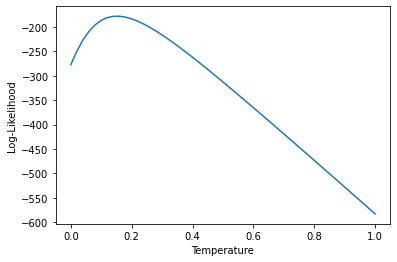

The maximum likelhood occurs at temp = 0.16


In [ ]:
# Parameter extimation using maximum likelihood estimator
params_choice = np.linspace(0, 1, 51)
fin = []
for param_choice in np.nditer(params_choice):
    param = [param_choice, 0, 1000, 4, 4, 2.1, 0.6]
    fin.append(-1*kf_sm_neglik(param, rews, chosen_idx))
plt.plot(params_choice, fin)
plt.ylabel('Log-Likelihood')
plt.xlabel('Temperature')
plt.show()
print('The maximum likelhood occurs at temp = ' + str(params_choice[fin.index(max(fin))]))

In [ ]:
# Parameter estimation using optimization - Bounded Nelder-Mead Simplex algorithm (as in the paper)
# temp = 0.5; mu0 = 0; sigma0 = 1000, sigma_eps = 4; sigma_xi = 4; lamb = 2.1; alpha = 0.6
LB = [0, 0, 0, 0, 0, 0, 0]
UB = [1, 5000, 5000, 5000, 5000, 2, 2]
param = np.array([0.5, 0.1, 1000, 4, 4, 1, 1])
cNM.constrNM(kf_sm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

{'allvecs': None,
 'fopt': 173.0024089656686,
 'funcalls': 1006,
 'iter': 653,
 'warnflag': 0,
 'xopt': array([3.01962734e-01, 7.92983116e-01, 3.88231266e+03, 3.78470004e+00,
        3.53057858e+00, 5.11350061e-01, 5.63248168e-01])}

The optimum value of the temperature is at 0.166, which is close to the one obtained graphically.

Since the actual value is 0.15, the model provides a good enough fit for the data. Statistical criteria to evaluate fit will be used in the final analysis.



In [ ]:
def dyn_softmax(x, temp0, i):
    temp = ((i+1)/10)**temp0
    # print(temp)
    # print(np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp))))
    # print(np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp))))
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def delta(x, rew, choice, eta, lamb, alpha):
    lr = np.zeros(4)
    lr[choice] = eta
    return x + np.multiply(lr, util(rew, lamb, alpha) - x)

def del_dsm_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    temp0 = param[0]
    mu0 = param[1]
    eta = param[2]
    lamb = param[3]
    alpha = param[4]
    m = mu0*np.ones((numTrials + 1, 4))
    loglik = 0
    for i in range(numTrials):
        # print(numTrials)
        # print('At i = ' + str(i) + ', ' + str(m[i]))
        prob = dyn_softmax(m[i], temp0, i)
        m[i+1] = delta(m[i], rews[i], int(chosen_idx[i]), eta, lamb, alpha)
        # print('temp = ' + str(temp0) + ', prob = ' + str(prob) + ', idx = ' + str(int(chosen_idx[i])))
        # print('in lik = ' + str(prob[int(chosen_idx[i])]))
        loglik += np.log(prob[int(chosen_idx[i])])
        # print(loglik)
    return -loglik

def play_del_dsm(rews, temp0, mu0, eta, lamb, alpha):
    numTrials = rews.shape[0]
    m = mu0*np.ones((numTrials+1, 4))
    chosen_idx = -1*np.ones(numTrials)
    for i in range(numTrials):
        chosen_idx[i] = np.random.choice(np.array([0, 1, 2, 3]), 1, False, dyn_softmax(m[i], temp0, i))
        m[i+1] = delta(m[i], rews[i], int(chosen_idx[i]), eta, lamb, alpha)
    return chosen_idx

In [ ]:
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
temp0 = 0.9; mu0 = 0; eta = 0.8; lamb = 0.5; alpha = 0.4
chosen_idx = play_del_dsm(rews, temp0, mu0, eta, lamb, alpha)

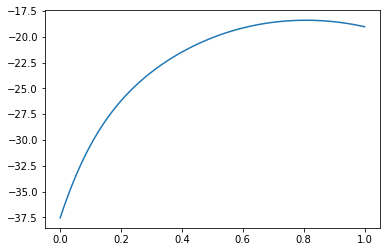

The maximum likelhood occurs at temp = 0.81


In [ ]:
params_choice = np.linspace(0, 1, 101)
fin = []
for param_choice in np.nditer(params_choice):
    param = [param_choice, 0, 0.8, 0.5, 0.4]
    fin.append(-1*del_dsm_neglik(param, rews, chosen_idx))
plt.plot(params_choice, fin)
plt.show()
print('The maximum likelhood occurs at temp = ' + str(params_choice[fin.index(max(fin))]))

In [ ]:
LB = [0.01, 0, 0, 0, 0]
UB = [2, 5000, 1, 2, 2]
param = np.array([0.1, 0.1, 0.5, 1, 1])
cNM.constrNM(del_dsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

{'allvecs': None,
 'fopt': 14.642505030692385,
 'funcalls': 263,
 'iter': 154,
 'warnflag': 0,
 'xopt': array([0.32814366, 0.39225472, 0.78067085, 0.87268425, 0.68955355])}

In [ ]:
def softmax(x, temp):
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def decay(x, rew, choice, eta_dec, lamb, alpha):
    y = np.zeros(4)
    y[choice] = 1
    return eta_dec*x + np.multiply(y, util(rew, lamb, alpha))

def dec_fsm_neglik(param, rews, chosen_idx):
    temp = param[0]
    mu0 = param[1]
    eta_dec = param[2]
    lamb = param[3]
    alpha = param[4]
    numTrials = rews.shape[0]
    m = mu0*np.ones((numTrials+1, 4))
    loglik = 0
    for i in range(numTrials):
        prob = softmax(m[i], temp)
        m[i+1] = decay(m[i], rews[i], int(chosen_idx[i]), eta_dec, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    return -loglik

def play_dec_fsm(rews, temp, mu0, eta_dec, lamb, alpha):
    numTrials = rews.shape[0]
    m = mu0*np.ones((numTrials+1, 4))
    chosen_idx = -1*np.ones(numTrials)
    for i in range(numTrials):
        # print(i, temp, mu0, eta_dec, lamb, alpha)
        # print('rew = ' + str(rews[i]))
        chosen_idx[i] = np.random.choice(np.array([0, 1, 2, 3]), 1, False, softmax(m[i], temp))
        m[i+1] = decay(m[i], rews[i], int(chosen_idx[i]), eta_dec, lamb, alpha)
    return chosen_idx

In [ ]:
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
temp = 0.6; mu0 = 0; eta_dec = 0.64; lamb = 2.06; alpha = 0.36
chosen_idx = play_dec_fsm(rews, temp, mu0, eta_dec, lamb, alpha)

In [ ]:
LB = [0.01, -1e-2, 0, 0, 0]
UB = [1, 1e-2, 1, 3, 3]
param = np.array([0.1, 0, 0.5, 1, 1])
cNM.constrNM(dec_fsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

{'allvecs': None,
 'fopt': 54.85355991606772,
 'funcalls': 276,
 'iter': 166,
 'warnflag': 0,
 'xopt': array([5.90894810e-01, 1.12498169e-03, 6.57392070e-01, 1.53648641e+00,
        3.66155236e-01])}

In [ ]:
def kalman(x_mean, x_var, rew, choice, sigma_xi, sigma_eps, lamb, alpha):
    k_gain = np.zeros(4)
    k_gain[choice] = (x_var[choice] + sigma_xi**2)/(x_var[choice] + sigma_xi**2 + sigma_eps**2)
    x_mean1 = x_mean + np.multiply(k_gain, util(rew, lamb, alpha) - x_mean)
    x_var1 = np.multiply(1 - k_gain, x_var + sigma_xi**2)
    return x_mean1, x_var1

def pmu(x_mean, x_var, sigma_eps):
    prob = -1*np.ones(4)
    for i in range(4):
        A = -1*np.identity(3)
        A = np.insert(A, i, np.array([1,1,1]), 1)
        M = np.matmul(A, x_mean)
        H = np.diag(x_var + sigma_eps**2)
        H = np.matmul(np.matmul(A, H), np.transpose(A))
        prob[i] = mvnun([0,0,0], [np.inf,np.inf,np.inf], M, H)[0]
    # print('a')
    # print(prob)
    # print('prob = ' + str(prob/np.sum(prob)))
    return prob/np.sum(prob)

def kf_pmu_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    mu0 = param[0]
    sigma0 = param[1]
    sigma_xi = param[2]
    sigma_eps = param[3]
    lamb = param[4]
    alpha = param[5]
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    loglik = 0
    for i in range(numTrials):
        prob = pmu(m[i], v[i], sigma_eps)
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
        loglik += np.log(prob[int(chosen_idx[i])])
    return -loglik

def play_kf_pmu(rews, mu0, sigma0, sigma_xi, sigma_eps, lamb, alpha):
    numTrials = rews.shape[0]
    chosen_idx = -1*np.ones(numTrials)
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    for i in range(numTrials):
        # print('i = ' + str(i) + ', m = ' + str(m[i]))
        chosen_idx[i] = np.random.choice(np.array([0, 1, 2, 3]), 1, False, pmu(m[i], v[i], sigma_eps))
        # print('choice = ' + str(chosen_idx[i]) + ', rew = ' + str(rews[i]))
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
    return chosen_idx

In [ ]:
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
mu0 = 0; sigma0 = 15; sigma_xi = 4; sigma_eps = 4; lamb = 0.9; alpha = 0.2
chosen_idx = play_kf_pmu(rews, mu0, sigma0, sigma_xi, sigma_eps, lamb, alpha)

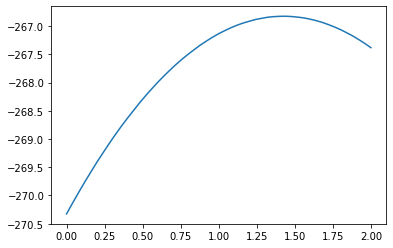

The maximum likelhood occurs at lamb = 1.44


In [ ]:
params_choice = np.linspace(0, 2, 51)
fin = []
for param_choice in np.nditer(params_choice):
    param = [0, 15, 4, 4, param_choice, 0.2]
    fin.append(-1*kf_pmu_neglik(param, rews, chosen_idx))
plt.plot(params_choice, fin)
plt.show()
print('The maximum likelhood occurs at lamb = ' + str(params_choice[fin.index(max(fin))]))

In [ ]:
LB = [0, 0, 0, 0, 0, 0]
UB = [10, 2000, 2000, 2000, 3, 3]
param = np.array([0.1, 2, 0.5, 1, 1, 1])
cNM.constrNM(kf_pmu_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


{'allvecs': None,
 'fopt': 266.2705167977605,
 'funcalls': 1205,
 'iter': 475,
 'warnflag': 1,
 'xopt': array([1.72038724e-03, 3.15066656e+01, 3.01166248e+00, 4.46004415e+00,
        1.61410661e+00, 1.59799436e-01])}

In [ ]:
def null_neglik(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    p = param[0]
    q = param[1]
    r = param[2]
    s = 1 - p - q - r
    x = np.array([p, q, r, s])
    loglik = 0
    for i in range(numTrials):
        # print(i)
        # print(int(chosen_idx[i]))
        # print(x[int(chosen_idx[i])])
        # print(np.log(x[int(chosen_idx[i])]))
        loglik += np.log(x[int(chosen_idx[i])])
    return -loglik

In [ ]:
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
temp = 0.2; mu0 = 0; sigma0 = 1000; sigma_eps = 4; sigma_xi = 4; lamb = 1.5; alpha = 0.6
chosen_idx = play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi, lamb, alpha)

In [ ]:
LB = [0, 0, 0]
UB = [1, 1, 1]
param = np.array([0.1, 0.1, 0.1])
cNM.constrNM(null_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

{'allvecs': None,
 'fopt': 263.1571606668192,
 'funcalls': 100,
 'iter': 53,
 'warnflag': 0,
 'xopt': array([0.24000391, 0.1100094 , 0.32000241])}

In [ ]:
def delta_aic(id, param_1, param_2, rews, chosen_idx):
    num1 = param_1.size
    num2 = param_2.size
    lik2 = -null_neglik(param_2, rews, chosen_idx)
    if id == 'kf_pmu':
        lik1 = -kf_pmu_neglik(param_1, rews, chosen_idx)
    elif id == 'dec_smf':
        lik1 = -dec_fsm_neglik(param_1, rews, chosen_idx)
    elif id == 'del_smd':
        lik1 = -del_dsm_neglik(param_1, rews, chosen_idx)
    aic1 = 2*(num1 - lik1)
    aic2 = 2*(num2 - lik2)
    return aic1, aic2, aic2 - aic1

def delta_bic(id, param_1, param_2, rews, chosen_idx, samp):
    num1 = param_1.size
    num2 = param_2.size
    lik2 = -null_neglik(param_2, rews, chosen_idx)
    if id == 'kf_pmu':
        lik1 = -kf_pmu_neglik(param_1, rews, chosen_idx)
    elif id == 'dec_smf':
        lik1 = -dec_fsm_neglik(param_1, rews, chosen_idx)
    elif id == 'del_smd':
        lik1 = -del_dsm_neglik(param_1, rews, chosen_idx)
    bic1 = num1*np.log(samp) - 2*lik1
    bic2 = num2*np.log(samp) - 2*lik2
    return bic1, bic2, bic2 - bic1

In [ ]:
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
temp = 0.2; mu0 = 0; sigma0 = 1000; sigma_eps = 4; sigma_xi = 4; lamb = 1.5; alpha = 0.6
chosen_idx = play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi, lamb, alpha)

In [ ]:
LB = [0, 0, 0]
UB = [1, 1, 1]
param = np.array([0.1, 0.1, 0.1])
ans = cNM.constrNM(null_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
param_2 = ans['xopt']
samp = 200

LB = [0.01, 0, 0, 0, 0]
UB = [2, 5000, 1, 2, 2]
param = np.array([0.1, 0.1, 0.5, 1, 1])
ans = cNM.constrNM(del_dsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
param_1 = ans['xopt']
id = 'del_smd'
print(id)
print(delta_aic(id, param_1, param_2, rews, chosen_idx))
print(delta_bic(id, param_1, param_2, rews, chosen_idx, samp))

LB = [0.01, -1e-2, 0, 0, 0]
UB = [1, 1e-2, 1, 3, 3]
param = np.array([0.1, 0, 0.5, 1, 1])
ans = cNM.constrNM(dec_fsm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
param_1 = ans['xopt']
id = 'dec_smf'
print(id)
print(delta_aic(id, param_1, param_2, rews, chosen_idx))
print(delta_bic(id, param_1, param_2, rews, chosen_idx, samp))

LB = [0, 0, 0, 0, 0, 0]
UB = [10, 2000, 2000, 2000, 3, 3]
param = np.array([0.1, 2, 0.5, 1, 1, 1])
ans = cNM.constrNM(kf_pmu_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)
param_1 = ans['xopt']
id = 'kf_pmu'
print(id)
print(delta_aic(id, param_1, param_2, rews, chosen_idx))
print(delta_bic(id, param_1, param_2, rews, chosen_idx, samp))



del_smd
(297.35808398031037, 529.257966872517, 231.89988289220668)
(313.8496708130506, 539.1529189721612, 225.30324815911058)
dec_smf
(325.09433739399276, 529.257966872517, 204.16362947852429)
(341.5859242267329, 539.1529189721612, 197.56699474542825)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


kf_pmu
(291.732457924843, 529.257966872517, 237.52550894767404)
(311.52239563725294, 539.1529189721612, 227.63052333490822)


In [ ]:
import numpy as np
x = np.array([1, 2, 3, 4])
x = np.delete(x, x == -1, 0)
print(x)

[1 2 3 4]
